In [42]:
# # Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh
# !pip install mecab-python3

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [45]:
text_data = pd.read_csv("/content/gdrive/MyDrive/와이빅타/신입기수플젝/한국어_단발성_대화_데이터셋.csv", usecols=[0,1])
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,걱정
1,그냥 내 느낌일뿐겠지?,걱정
2,아직너무초기라서 그런거죠?,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
43666,NaN,NaN
43667,NaN,NaN
43668,NaN,NaN
43669,NaN,NaN


# 결측치, 중복값 삭제

In [46]:
text_data.isnull().any()

Sentence    True
Emotion     True
dtype: bool

In [47]:
text_data =text_data.dropna(axis=0) # 결측치 삭제

In [48]:
text_data['Sentence'].nunique(), text_data['Emotion'].nunique() # Sentece 열에서 중복 확인

(41534, 5)

In [49]:
# text_data = text_data.drop_duplicates(subset=['Sentence']) # Sentece 열에서 중복 제거
# print('총 텍스트 샘플 수 :', len(text_data))

In [50]:
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,걱정
1,그냥 내 느낌일뿐겠지?,걱정
2,아직너무초기라서 그런거죠?,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
41639,너무 힘들어요…,슬픔
41640,"저는 원래 자존감계속되는 취업 실패에 , 그것에 대한 부모님의 실망과 눈치를 정말 ...",슬픔
41641,아버지 술주정+어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함.포기해야할까요...,슬픔
41642,너 그거알아? 나만 느끼는거인지 모르겠는데 너 진짜 예뻐 그리고 멋있어,행복


# 구두점 제거

In [51]:
import re

# 데이터 전처리: 구두점 제거
def data_preprocessing(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

cnt=0
for i in text_data['Sentence']:
    # print(i)
    text_data['Sentence'][cnt] = re.sub(r'[^\w\s]','',i)
    cnt+=1
text_data[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,걱정
1,그냥 내 느낌일뿐겠지,걱정
2,아직너무초기라서 그런거죠,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
5,남자친구가 떠날까봐요,걱정
6,이거 했는데 허리가 아플수도 있나요,걱정
7,내가불안해서꾸는걸까,걱정
8,일주일도 안 남았당ㅠㅠ,걱정
9,약은 최대한 안먹으려고 하는데좋은 음시있나요0,걱정


In [52]:
text_data['Sentence'] = text_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
text_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,걱정
1,그냥 내 느낌일뿐겠지,걱정
2,아직너무초기라서 그런거죠,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정


In [53]:
text_3 = text_data.copy()
text_3['Emotion'] = text_3['Emotion'].replace(['걱정', '슬픔', '평온'], '중립')
text_3

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,중립
1,그냥 내 느낌일뿐겠지,중립
2,아직너무초기라서 그런거죠,중립
3,유치원버스 사고 낫다던데,중립
4,근데 원래이런거맞나요,중립
...,...,...
41639,너무 힘들어요,중립
41640,저는 원래 자존감계속되는 취업 실패에 그것에 대한 부모님의 실망과 눈치를 정말 많...,중립
41641,아버지 술주정어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함포기해야할까요버텨...,중립
41642,너 그거알아 나만 느끼는거인지 모르겠는데 너 진짜 예뻐 그리고 멋있어,행복


# Emotion 인코딩


In [54]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(text_3.Emotion)
Emotion_encoded = label_encoder.transform(text_3.Emotion)

In [55]:
text_3.Emotion = Emotion_encoded
text_3

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,1
1,그냥 내 느낌일뿐겠지,1
2,아직너무초기라서 그런거죠,1
3,유치원버스 사고 낫다던데,1
4,근데 원래이런거맞나요,1
...,...,...
41639,너무 힘들어요,1
41640,저는 원래 자존감계속되는 취업 실패에 그것에 대한 부모님의 실망과 눈치를 정말 많...,1
41641,아버지 술주정어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함포기해야할까요버텨...,1
41642,너 그거알아 나만 느끼는거인지 모르겠는데 너 진짜 예뻐 그리고 멋있어,2


In [56]:
print(label_encoder.classes_, "=>", label_encoder.transform(label_encoder.classes_))

['분노' '중립' '행복'] => [0 1 2]


# 훈련 데이터와 테스트 데이터 분리

In [59]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in splitter.split(text_3, text_3["Emotion"]):
    train_data = text_3.loc[train_index]
    test_data = text_3.loc[test_index]

# 토큰화

In [64]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '나', '사람', '주', '아니', '등', '같', '우리', '때', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '알', '그러나', '받', '일', '그런', '또', '사회', '많', '그리고', '중', '따르', '만들', '지금', '고', '다'] # 불용어

In [ ]:
train_data

In [65]:
train_data['tokenized'] = train_data['Sentence'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [66]:
test_data['tokenized'] = test_data['Sentence'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어와 길이 분포 확인

In [62]:
# worry_words = np.hstack(train_data[train_data.Emotion == 0]['tokenized'].values)
negative_words = np.hstack(train_data[train_data.Emotion == 0]['tokenized'].values)
# sad_words = np.hstack(train_data[train_data.Emotion == 2]['tokenized'].values)
# calmn_words = np.hstack(train_data[train_data.Emotion == 3]['tokenized'].values)
neutral_words = np.hstack(train_data[train_data.Emotion == 1]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.Emotion == 2]['tokenized'].values)

In [ ]:
worry_word_count = Counter(worry_words)
print(worry_word_count.most_common(20))

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

In [ ]:
sad_word_count = Counter(sad_words)
print(sad_word_count.most_common(20))

In [ ]:
calmn_word_count = Counter(calmn_words)
print(calmn_word_count.most_common(20))

In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

In [ ]:
fig,(ax2,ax1) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['Emotion']==1]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Negative Sentence')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['Emotion']==4]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Positive Sentence')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

plt.show()

In [67]:
X_train = train_data['tokenized'].values
y_train = train_data['Emotion'].values
X_test= test_data['tokenized'].values
y_test = test_data['Emotion'].values

# 정수 인코딩

In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [69]:
print(tokenizer.word_index)

{'거': 1, '면': 2, '안': 3, '아': 4, '어': 5, '는데': 6, '없': 7, '겠': 8, '만': 9, '너무': 10, '해': 11, '좋': 12, '네요': 13, '내': 14, '으로': 15, '로': 16, '진짜': 17, '싶': 18, '했': 19, '기': 20, '에서': 21, '었': 22, 'ㅋㅋ': 23, '할': 24, '잘': 25, 'ㅋㅋㅋ': 26, '않': 27, '어요': 28, '저': 29, '야': 30, '냐': 31, '니': 32, '살': 33, '힘들': 34, '라': 35, '생각': 36, '더': 37, 'ㅠㅠ': 38, '못': 39, '서': 40, '친구': 41, '년': 42, '왜': 43, '정말': 44, '합니다': 45, '습니다': 46, '으면': 47, '았': 48, '그냥': 49, '자': 50, '지만': 51, '좀': 52, '시': 53, '적': 54, '나라': 55, '던': 56, '님': 57, '해서': 58, '제': 59, '먹': 60, '죽': 61, '라고': 62, '행복': 63, '음': 64, '뭐': 65, '까지': 66, '해야': 67, '요': 68, '다고': 69, '한테': 70, '오늘': 71, '면서': 72, '이런': 73, '감사': 74, '모르': 75, '세요': 76, '건': 77, '어서': 78, '사': 79, '많이': 80, '이제': 81, '데': 82, '전': 83, '인데': 84, '돈': 85, '분': 86, '어떻게': 87, '에게': 88, '난': 89, '죠': 90, '개': 91, '너': 92, '보다': 93, '마음': 94, '부터': 95, '국민': 96, '날': 97, '남': 98, '번': 99, '줄': 100, '하나': 101, '다는': 102, '길': 103, '참': 104, '걸': 105, '라는': 10

In [70]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 22464
등장 빈도가 2번 이하인 희귀 단어의 수: 14241
단어 집합에서 희귀 단어의 비율: 63.39476495726496
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.601893653670783


In [71]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8225


In [72]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [73]:
print(X_train[:3])

[[1351, 1063, 15, 2371], [1301, 217, 6485, 16, 4], [29, 10, 529, 80, 8224]]


In [74]:
print(X_test[:3])

[[1648, 24, 65, 62, 1248, 12, 431], [1065, 2534, 1394, 55, 106, 4042, 88, 1880, 322, 15, 4042, 1047, 22, 6, 81, 2186, 96, 9, 1909, 157, 1257, 817, 98, 48], [1828, 348, 3204, 65, 232, 67, 8, 236, 509, 15, 20]]


# 패딩

리뷰의 최대 길이 : 401
리뷰의 평균 길이 : 8.537873070325901


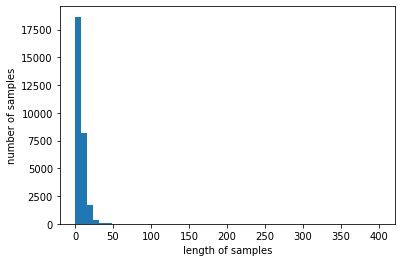

In [75]:
print('리뷰의 최대 길이 :',max(len(sentence) for sentence in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sentence) for sentence in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [76]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [77]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.84219554030874


In [78]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU로 감성 분류

In [90]:
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
365/365 [==============================] - ETA: 0s - loss: 0.6948 - acc: 0.6917
Epoch 1: val_acc improved from -inf to 0.74974, saving model to best_model.h5
365/365 [==============================] - 8s 13ms/step - loss: 0.6948 - acc: 0.6917 - val_loss: 0.5855 - val_acc: 0.7497
Epoch 2/15
364/365 [============================>.] - ETA: 0s - loss: 0.4641 - acc: 0.8102
Epoch 2: val_acc did not improve from 0.74974
365/365 [==============================] - 4s 11ms/step - loss: 0.4643 - acc: 0.8102 - val_loss: 0.6059 - val_acc: 0.7393
Epoch 3/15
364/365 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8491
Epoch 3: val_acc did not improve from 0.74974
365/365 [==============================] - 4s 10ms/step - loss: 0.3779 - acc: 0.8491 - val_loss: 0.6533 - val_acc: 0.7352
Epoch 4/15
362/365 [============================>.] - ETA: 0s - loss: 0.3146 - acc: 0.8786
Epoch 4: val_acc did not improve from 0.74974
365/365 [==============================] - 4s 10ms/ste

In [91]:
loaded_model = load_model('best_model.h5')
loaded_model.save('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

391/391 [==============================] - 2s 4ms/step - loss: 0.5764 - acc: 0.7559

 테스트 정확도: 0.7559


In [ ]:
# from google.colab import files
# files.download('best_model.h5')

In [ ]:
# model = load_model('/content/gdrive/MyDrive/와이빅타/신입기수플젝/best_model.h5')

# 중립 모델

In [153]:
# text_neutral = text_data.copy()
# text_neutral['Emotion'] = text_3['Emotion'].replace(['걱정', '슬픔', '평온'], '중립')
text_neutral = text_data.loc[text_data['Emotion'].isin(['걱정', '슬픔', '평온'])]
text_neutral

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,걱정
1,그냥 내 느낌일뿐겠지,걱정
2,아직너무초기라서 그런거죠,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
41638,살고싶다 매일 매일 나를 절벽 끝으로 모는 이들이 무섭다,슬픔
41639,너무 힘들어요,슬픔
41640,저는 원래 자존감계속되는 취업 실패에 그것에 대한 부모님의 실망과 눈치를 정말 많...,슬픔
41641,아버지 술주정어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함포기해야할까요버텨...,슬픔


In [154]:
label_encoder_neut = LabelEncoder()
label_encoder_neut.fit(text_neutral.Emotion)
Emotion_encoded_neut = label_encoder_neut.transform(text_neutral.Emotion)

In [155]:
text_neutral.Emotion = Emotion_encoded_neut
text_neutral

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,0
1,그냥 내 느낌일뿐겠지,0
2,아직너무초기라서 그런거죠,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
41638,살고싶다 매일 매일 나를 절벽 끝으로 모는 이들이 무섭다,1
41639,너무 힘들어요,1
41640,저는 원래 자존감계속되는 취업 실패에 그것에 대한 부모님의 실망과 눈치를 정말 많...,1
41641,아버지 술주정어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함포기해야할까요버텨...,1


In [156]:
print(label_encoder_neut.classes_, "=>", label_encoder_neut.transform(label_encoder_neut.classes_))

['걱정' '슬픔' '평온'] => [0 1 2]


In [157]:
text_neutral = text_neutral.reset_index()
text_neutral.drop('index', inplace=True, axis=1)

In [158]:
print(text_neutral)

                                                Sentence  Emotion
0                                   언니 동생으로 부르는게 맞는 일인가요        0
1                                            그냥 내 느낌일뿐겠지        0
2                                          아직너무초기라서 그런거죠        0
3                                          유치원버스 사고 낫다던데        0
4                                            근데 원래이런거맞나요        0
...                                                  ...      ...
21884                    살고싶다 매일 매일 나를 절벽 끝으로 모는 이들이 무섭다        1
21885                                            너무 힘들어요        1
21886  저는 원래 자존감계속되는 취업 실패에  그것에 대한 부모님의 실망과 눈치를 정말 많...        1
21887  아버지 술주정어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함포기해야할까요버텨...        1
21888                             모든 사람이 다 저를 싫어하는 것 같아요        1

[21889 rows x 2 columns]


In [159]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in splitter.split(text_neutral, text_neutral["Emotion"]):
    train_data = text_neutral.loc[train_index]
    test_data = text_neutral.loc[test_index]

In [160]:
train_data['tokenized'] = train_data['Sentence'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [161]:
test_data['tokenized'] = test_data['Sentence'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [162]:
worry_words = np.hstack(train_data[train_data.Emotion == 0]['tokenized'].values)
sad_words = np.hstack(train_data[train_data.Emotion == 1]['tokenized'].values)
calmn_words = np.hstack(train_data[train_data.Emotion == 2]['tokenized'].values)

In [163]:
X_train = train_data['tokenized'].values
y_train = train_data['Emotion'].values
X_test= test_data['tokenized'].values
y_test = test_data['Emotion'].values

In [164]:
tokenizer_n = Tokenizer()
tokenizer_n.fit_on_texts(X_train)

In [165]:
threshold = 3
total_cnt = len(tokenizer_n.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer_n.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15092
등장 빈도가 2번 이하인 희귀 단어의 수: 10064
단어 집합에서 희귀 단어의 비율: 66.68433607209117
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.32203446996526


In [166]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5030


In [167]:
tokenizer_n = Tokenizer(vocab_size) 
tokenizer_n.fit_on_texts(X_train)
X_train = tokenizer_n.texts_to_sequences(X_train)
X_test = tokenizer_n.texts_to_sequences(X_test)

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [168]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.75851716486098


In [169]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [170]:
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model_neut = Sequential()
model_neut.add(Embedding(vocab_size, embedding_dim))
model_neut.add(GRU(hidden_units))
model_neut.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_neut.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_neut.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_neut.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
187/192 [============================>.] - ETA: 0s - loss: 0.9154 - acc: 0.5649
Epoch 1: val_acc improved from -inf to 0.65775, saving model to best_model_neut.h5
192/192 [==============================] - 4s 13ms/step - loss: 0.9120 - acc: 0.5679 - val_loss: 0.7910 - val_acc: 0.6577
Epoch 2/15
189/192 [============================>.] - ETA: 0s - loss: 0.6660 - acc: 0.7191
Epoch 2: val_acc improved from 0.65775 to 0.65905, saving model to best_model_neut.h5
192/192 [==============================] - 2s 11ms/step - loss: 0.6664 - acc: 0.7187 - val_loss: 0.8017 - val_acc: 0.6591
Epoch 3/15
189/192 [============================>.] - ETA: 0s - loss: 0.5554 - acc: 0.7692
Epoch 3: val_acc did not improve from 0.65905
192/192 [==============================] - 2s 10ms/step - loss: 0.5551 - acc: 0.7695 - val_loss: 0.8715 - val_acc: 0.6336
Epoch 4/15
190/192 [============================>.] - ETA: 0s - loss: 0.4785 - acc: 0.8058
Epoch 4: val_acc did not improve from 0.65905
192/192 [

In [172]:
loaded_model_neut = load_model('best_model_neut.h5')
loaded_model_neut.save('best_model_neut.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_neut.evaluate(X_test, y_test)[1]))

206/206 [==============================] - 2s 7ms/step - loss: 0.8344 - acc: 0.6301

 테스트 정확도: 0.6301


# 감성 예측

In [197]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = loaded_model.predict(pad_new)
  print("부정 중립 긍정")
  print(score[0])
  clean_score = list(score[0])
  # print(clean_score)

  if clean_score.index(max(clean_score)) == 1:
    score_neut = loaded_model_neut.predict(pad_new)
    print("걱정 슬픔 평온")
    print(score_neut)
  # if(score > 0.5):
  #   print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  # else:
  #   print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [198]:
sentiment_predict('상수야 개패기전에 그만개겨라')

부정 중립 긍정
[0.72416615 0.23556414 0.04026968]


In [199]:
sentiment_predict('무슨 똑같은말만 40분을 하네 ;;;;')

부정 중립 긍정
[0.72839105 0.25358087 0.0180281 ]


In [200]:
sentiment_predict('귀요미 끝판왕')

부정 중립 긍정
[0.35686707 0.21758707 0.42554593]


In [201]:
sentiment_predict('형 나 형 쇼미하는거 보고왔서 형 랩 엄청 잘하네!! 열심히해!!')

부정 중립 긍정
[0.02162778 0.21310425 0.76526797]


In [202]:
sentiment_predict('상수야 현피 함 뜨자 연락해라')

부정 중립 긍정
[0.2461114  0.7104324  0.04345623]
걱정 슬픔 평온
[[0.20761438 0.6728087  0.11957692]]


In [203]:
sentiment_predict('방송 접자 그냥.')

부정 중립 긍정
[0.31351736 0.4812518  0.20523079]
걱정 슬픔 평온
[[0.11972563 0.16723208 0.7130423 ]]


In [204]:
sentiment_predict('상수야 경찰 떳는데 혹시 또 테이저건 맞았냐?')

부정 중립 긍정
[0.34337914 0.6427885  0.01383237]
걱정 슬픔 평온
[[0.5004226  0.45911875 0.04045866]]


In [205]:
sentiment_predict('진짜 요즘 텐션 지렸다ㅋㅋ')

부정 중립 긍정
[0.25477952 0.4893271  0.25589335]
걱정 슬픔 평온
[[0.06587911 0.04483716 0.8892837 ]]


In [206]:
sentiment_predict('상수야 나 5살인데 말 놓을게')

부정 중립 긍정
[0.30156544 0.68559474 0.01283984]
걱정 슬픔 평온
[[0.2907739  0.6282475  0.08097858]]


In [207]:
sentiment_predict('형님  여자친구와 오늘 헤어젔습니다   울어야하는데  형님 방송보면서 실실 쪼개고 있는  저 자신이 ㅄ같지만  형님떄문에 힘이납니다  맨날 방송해주세요  그래야 다시일어설수있을꺼같습니다')

부정 중립 긍정
[0.10622775 0.5006699  0.39310238]
걱정 슬픔 평온
[[0.53046566 0.29520363 0.17433071]]


In [208]:
sentiment_predict('상수형 진짜 저랑 생방으로 딱 한번만 현피떠주시면 안될까요?')

부정 중립 긍정
[0.09132314 0.9038776  0.00479921]
걱정 슬픔 평온
[[0.41797668 0.5419426  0.04008068]]


In [209]:
sentiment_predict('나잇값 못하이 맞았겠지 상수야 ㅋㅋㅋㅋㅋ')

부정 중립 긍정
[0.30335745 0.4687834  0.22785912]
걱정 슬픔 평온
[[0.19647944 0.7063743  0.09714628]]


In [210]:
sentiment_predict('나랑 현피 뜨실 니어디산 아 대구에 산다 탈모 병신 새끼야')

부정 중립 긍정
[0.78932136 0.19932179 0.0113569 ]
